In [9]:
# importing required libraries
import numpy as np 
import pandas as pd 
%matplotlib inline 
import matplotlib.pyplot as plt
import os
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import cv2
import string
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [10]:
img_shape = [50, 200, 1] #Shape of given image

In [11]:
character= string.ascii_lowercase + "0123456789" # All symbols captcha can contain
nchar = len(character) #total number of char possible
nchar

36

In [12]:
! gdown --id 1cr4JiHgqai3JFCbs3sqfkhrhfnRe9X3a  #Uploding data from google drive

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1cr4JiHgqai3JFCbs3sqfkhrhfnRe9X3a
To: /content/dataset.zip
100% 9.17M/9.17M [00:00<00:00, 197MB/s]


In [13]:
! unzip dataset.zip #Unziping the data

Archive:  dataset.zip
replace samples/226md.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: samples/226md.png       
replace samples/22d5n.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: samples/22d5n.png       
  inflating: samples/2356g.png       
  inflating: samples/23mdg.png       
  inflating: samples/23n88.png       
  inflating: samples/243mm.png       
  inflating: samples/244e2.png       
  inflating: samples/245y5.png       
  inflating: samples/24f6w.png       
  inflating: samples/24pew.png       
  inflating: samples/25257.png       
  inflating: samples/253dc.png       
  inflating: samples/25egp.png       
  inflating: samples/25m6p.png       
  inflating: samples/25p2m.png       
  inflating: samples/25w53.png       
  inflating: samples/264m5.png       
  inflating: samples/268g2.png       
  inflating: samples/28348.png       
  inflating: samples/28x47.png       
  inflating: samples/2b827.png       
  inflating: samples/2bg48.png       
  inflat

In [14]:
n=len(os.listdir("/content/samples")) #Number of test samples

In [15]:
def create_model():

    img = layers.Input(shape=img_shape) # Get image as an input of size 50,200,1
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img) #50*200
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 25*100
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 13*50
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3) #to improve the stability of model
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 7*25
    
    flat = layers.Flatten()(mp3) #convert the layer into 1-D

    outs = []
    for _ in range(5): #for 5 letters of captcha (just like LSTM)
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1) #drops 0.5 fraction of nodes
        res = layers.Dense(nchar, activation='sigmoid')(drop)

        outs.append(res) #result of layers
    
    # Compile model and return it
    model = Model(img, outs) #create model
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [16]:
def preprocess_data():
    n_samples = len(os.listdir('/content/samples')) #Number of training samples
    X = np.zeros([n_samples, 50, 200, 1]) #1070*50*200
    y = np.zeros([5, n_samples, nchar]) #5*1070*36
    i=0
    for pic in (os.listdir('/content/samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('/content/samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]    # captcha to be predicted
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0 #normalize
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, nchar))
            for j, l in enumerate(pic_target):
                ind = character.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
            i+=1
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [17]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 200, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 100, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 100, 32)  4640        ['max_pooling2d[0][0]']      

In [18]:
# training the model
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Epoch 1/30
25/25 [==============================] - 11s 46ms/step - loss: 17.8923 - dense_1_loss: 3.5915 - dense_3_loss: 3.5621 - dense_5_loss: 3.5922 - dense_7_loss: 3.5877 - dense_9_loss: 3.5588 - dense_1_accuracy: 0.0490 - dense_3_accuracy: 0.0799 - dense_5_accuracy: 0.0451 - dense_7_accuracy: 0.0503 - dense_9_accuracy: 0.0528 - val_loss: 17.6415 - val_dense_1_loss: 3.5350 - val_dense_3_loss: 3.5116 - val_dense_5_loss: 3.5273 - val_dense_7_loss: 3.5414 - val_dense_9_loss: 3.5262 - val_dense_1_accuracy: 0.0825 - val_dense_3_accuracy: 0.0515 - val_dense_5_accuracy: 0.0619 - val_dense_7_accuracy: 0.0619 - val_dense_9_accuracy: 0.0773
Epoch 2/30
25/25 [==============================] - 0s 14ms/step - loss: 16.6784 - dense_1_loss: 3.2548 - dense_3_loss: 3.3454 - dense_5_loss: 3.3467 - dense_7_loss: 3.3746 - dense_9_loss: 3.3568 - dense_1_accuracy: 0.0889 - dense_3_accuracy: 0.0696 - dense_5_accuracy: 0.0657 - dense_7_accuracy: 0.0709 - dense_9_accuracy: 0.0503 - val_loss: 17.4838 - val_d

In [19]:
# predicting captcha from image
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0   # normalize
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))

    captcha = ''
    for l in l_ind:
        captcha +=character[l]
    return captcha

In [20]:
# evaluating model accuracy
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)

4/4 [==============================] - 0s 21ms/step - loss: 2.3199 - dense_1_loss: 0.0249 - dense_3_loss: 0.2787 - dense_5_loss: 0.6147 - dense_7_loss: 0.7522 - dense_9_loss: 0.6493 - dense_1_accuracy: 0.9900 - dense_3_accuracy: 0.8600 - dense_5_accuracy: 0.8100 - dense_7_accuracy: 0.8000 - dense_9_accuracy: 0.8200
Test Loss and accuracy: [2.319852828979492, 0.024871308356523514, 0.27868422865867615, 0.614717423915863, 0.7522320747375488, 0.6493476629257202, 0.9900000095367432, 0.8600000143051147, 0.8100000023841858, 0.800000011920929, 0.8199999928474426]


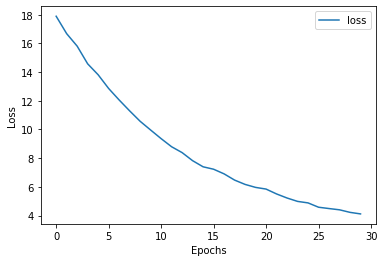

In [21]:
# assessing loss function
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

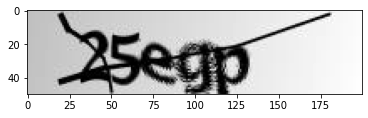

In [22]:
img=cv2.imread('/content/samples/25egp.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [23]:
print("Predicted Captcha =",predict('/content/samples/25egp.png'))

1/1 [==============================] - 0s 197ms/step
Predicted Captcha = 25egp
